In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import rioxarray
from tqdm import tqdm
from prescribed.utils import prepare_template
from rasterio import transform
from prescribed.utils import expand_grid
from prescribed.plot import template_plots

In [2]:
policy_size = 1_000_000
size_rx = 2_000

print(f"Number of policy 1 sq-km pixels: {policy_size / 247.105}")
print(f"If all fires are of {size_rx} acres, then the size is: {size_rx / 247.105} sq-km")
print(f"Number of fires in the policy area: {policy_size / size_rx}")

Number of policy 1 sq-km pixels: 4046.8626697153036
If all fires are of 2000 acres, then the size is: 8.093725339430607 sq-km
Number of fires in the policy area: 500.0


In [3]:
def simulation_data(template: str | pd.DataFrame, 
                    land_type: str | pd.DataFrame, 
                    roads: list | pd.DataFrame, 
                    only_roads: bool = True,
                    buf: int = 4_000,
                    road_type: str | None = "secondary",
                    crs: str = "EPSG:3310") -> pd.DataFrame:
    """ Set up data ready for Rx fire simulations

    This function will take a template of points and then subset them to get a 
    sampling space that is close to roads by different land types. 

    Parameters
    ----------
    template : geopandas.GeoDataFrame
        A geopandas dataframe with the template data
    land_type : pd.DataFrame
        A pandas dataframe with the land type data
    roads : geopandas.GeoDataFrame
        A geopandas dataframe with the road data
    buf : int
        The buffer distance to use for the roads
    
    Returns
    -------
        pd.DataFrame
            A pandas dataframe with the simulation data
    """

    cols_interest = [
        "lat", "lon", "grid_id", "land_type",
    ]

    # Load all datasets
    if isinstance(template, str):
        template = prepare_template(template).groupby("grid_id").first().reset_index()
        template = gpd.GeoDataFrame(template, 
                                    geometry=gpd.points_from_xy(template.lon, template.lat), 
                                    crs = crs)
    
    if isinstance(land_type, str):
        land_type = pd.read_feather(land_type).drop(columns=["lat", "lon"], errors="ignore")
    
    if only_roads:

        cols_interest = cols_interest + ["name", "fclass"]

        # Load the roads
        if isinstance(roads, list):
            roads = [gpd.read_file(road) for road in roads]
            roads = [road[road.fclass == road_type] for road in roads]
            roads = pd.concat(roads)
        
        # Buffer the roads
        roads["geometry"] = roads.to_crs(crs).buffer(buf)

        # Spatial join the template and the roads
        template = template.overlay(roads, how="intersection")

    # Merge with the land_type
    template = template.merge(land_type, on="grid_id")

    # Remove repeated pixels in the template
    # This can happens as windy roads or close roads will have the same pixel
    # in its buffer
    template = template.drop_duplicates(subset=["grid_id"])

    return template[cols_interest]

def sample_rx_years(template: str | pd.DataFrame, 
                    treat_data: pd.DataFrame, 
                    fire_data: pd.DataFrame,
                    estimates: pd.DataFrame | str,
                    size_treatment: int | None, 
                    start_year: int = 2010,
                    sample_n: int = 100,
                    crs: str = "EPSG:3310",
                ) -> pd.DataFrame:
    """ Sample years for Rx fires 

    This function will take the template data with buffered roads and sample
    points from the subset to select as treatments. The sample can also be of
    a specific size in which case we draw a square buffer in meters around the
    sampled point and get all the grid_ids that are within that buffer.

    Sampling is done without replacement, so if a pixels is selected in a year
    it won't be selected again for other years. 

    Parameters
    ----------
    template : geopandas.GeoDataFrame or str
        A geopandas dataframe with the template data
    treat_data : pd.DataFrame
        A pandas dataframe with the treatment data
    fire_data : pd.DataFrame
        A pandas dataframe with the MTBS treatment data
    size_treatment : int
        The size of the treatment in meters
    sample_n : int
        The number of samples to take per year
    start_year : int
        The year to start sampling from. This would be the first year of
        treatment
    crs: str
        The coordinate reference system to use. Default is California Albers
        with meters as units. 

    Returns
    -------
        pd.DataFrame
            A pandas dataframe with the sampled years
    """

    # Load all datasets
    if isinstance(template, str):
        template = prepare_template(template, years=[2000, 2022])
        template = gpd.GeoDataFrame(template, 
                                    geometry=gpd.points_from_xy(template.lon, template.lat), 
                                    crs = crs)
        template = template[template.year >= start_year]

    # Load fire data
    if isinstance(fire_data, str):
        fire_data = pd.read_feather(fire_data).drop(columns=["spatial_ref"], errors="ignore")

    # Load RR results from SC 
    if isinstance(estimates, str):
        estimates = pd.read_csv(estimates)
    else:
        estimates = estimates.copy(deep=True)

    # Change lags to years!
    estimates["year"] = start_year + estimates.year

    # Subset for the years we are interested in the treatment data
    fire_data = fire_data[fire_data.year >= start_year]
    
    # Merge treats with the template so we get full years
    template = template.merge(
        treat_data.drop(columns=["lat", "lon"], errors="ignore"), on="grid_id"
        )
    template = template.merge(fire_data, on=["lat", "lon", "year"], how="left")

    # Create weight for sampling. We want to downweight to sample units w/
    # fires in that year
    template["weight"] = 100
    template.loc[(~template.Event_ID.isna()) & 
                 (template.year == 2010) , "weight"] = 0.1

    # Sample the data by year without replacement across years
    sampled_years = []
    sample_grids = []
    for g_idx, df in tqdm(template.groupby("year"), desc="Sampling years", total=template.year.nunique(), leave=False):

        # Clean df and remove all the grids that were sampled before
        df = df[~df.grid_id.isin(sample_grids)]
        sample = df.sample(n=sample_n, weights="weight")

        # Not the same grids on each year
        sample_grids.extend(sample.grid_id.unique())

        # Follow these sample in time! (notice is hardcoded to 2011 to 2022)
        sample_grid = expand_grid({"grid_id": sample.grid_id.unique(), 
                                   "year": range(g_idx + 1, 2023)})

        # Get the land type back
        sample = sample_grid.merge(sample[["grid_id", "land_type", "lat", "lon"]], on="grid_id", how="left")

        # Add coeffs and the high and low CIs so we can sample values later!
        sample = sample.merge(estimates, on=["land_type", "year"], how="left")
        sample["year_treat"] = g_idx

        # Randomily pick within the CIs
        #sample["coeff"] = np.random.uniform(sample.low_ci, sample.high_ci)
        sample["coeff"] = np.random.normal(loc=sample.coef, scale=sample.se)
 
        if size_treatment > 1000:
            sample["geometry"] = sample.buffer(size_treatment, cap_style="square")
            sample = sample.overlay(df, how="intersects")
            sample = sample.drop_duplicates(subset=["grid_id"])

        sampled_years.append(sample)
    
    sampled_years = pd.concat(sampled_years)

    return sampled_years

In [4]:
sim_data = simulation_data(
    template="/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif", 
    land_type="/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather", 
    roads=["/mnt/sherlock/oak/prescribed_data/raw/os_roads_ca/norcal/gis_osm_roads_free_1.shp",
           "/mnt/sherlock/oak/prescribed_data/raw/os_roads_ca/socal/gis_osm_roads_free_1.shp"
           ],
    only_roads = False,
    buf=10_000,
    road_type="secondary",
)

In [5]:
template = prepare_template("/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif")

dnbr = pd.read_feather("/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/dnbr_long.feather")
mtbs = gpd.read_file("/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp").to_crs("EPSG:3310")

# Merge it to get years
mtbs["year"] = mtbs.Ig_Date.dt.year

mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")]

dnbr = dnbr.merge(mtbs[["Event_ID", "year"]], right_on="Event_ID", left_on="event_id", how="left")
dnbr.drop(columns=["Event_ID"], inplace=True)

# Merge with template to add all the grids
dnbr = template.merge(dnbr.drop(columns=["lat", "lon"]), on=["grid_id", "year"], how="left")

# # Solve overlapping repeats by taking the max
dnbr = dnbr.set_index(["lat", "lon", "year"])

# Create xarray object
dnbr_arr = dnbr[~dnbr.index.duplicated()].dnbr.to_xarray()

In [6]:
# Prepare results
results = pd.read_csv("../data/results/att_conifers_dnbr.csv")
results["land_type"] = results.land_type.replace({"conifers": 2.0, "shrublands": 12.0})

sim_data = sim_data[sim_data.land_type.isin([2])]

# Prepare fire data
fire_data = (
    pd.read_feather("/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather")
    .drop(columns=["spatial_ref"], errors="ignore")
)
fire_data = fire_data[fire_data.year >= 2010]

# Prepare template
template = prepare_template("/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif", 
                            years=[2000, 2022])
template = gpd.GeoDataFrame(template, 
                            geometry=gpd.points_from_xy(template.lon, template.lat), 
                            crs = "EPSG:3310")
template = template[template.year >= 2010]

In [7]:
from itertools import zip_longest

def grouper(iterable, n, *, incomplete='fill', fillvalue=None):
    "Collect data into non-overlapping fixed-length chunks or blocks."
    # grouper('ABCDEFG', 3, fillvalue='x') → ABC DEF Gxx
    # grouper('ABCDEFG', 3, incomplete='strict') → ABC DEF ValueError
    # grouper('ABCDEFG', 3, incomplete='ignore') → ABC DEF
    iterators = [iter(iterable)] * n
    match incomplete:
        case 'fill':
            return zip_longest(*iterators, fillvalue=fillvalue)
        case 'strict':
            return zip(*iterators, strict=True)
        case 'ignore':
            return zip(*iterators)
        case _:
            raise ValueError('Expected fill, strict, or ignore')


In [25]:
# Supress warnings
import warnings
warnings.filterwarnings("ignore")

for group_sims in tqdm(grouper(range(1, 100), 10), total=10, desc="Grouping simulations"):
    arr_lst = []
    for idx in group_sims:
        sample_rx = sample_rx_years(
            template=template, 
            treat_data=sim_data,
            estimates=results,
            fire_data=fire_data,
            size_treatment=1_000,
            start_year=2010,
            sample_n=6_000,
            crs="EPSG:3310",
        )

        test_arr = sample_rx.copy()
        test_arr = test_arr.merge(template, on=["lat", "lon", "year", "grid_id"], how="right")
        test_arr['coeff'] = test_arr['coeff'].fillna(0)

        test_arr = test_arr.set_index(["lat", "lon", "year", "year_treat"])[["coeff"]].to_xarray()

        # Add dimension to the array
        test_arr = test_arr.expand_dims({"sim": [idx]})
        arr_lst.append(test_arr)

    # Concatenate all the arrays
    test_arr = xr.concat(arr_lst, dim="sim").to_netcdf(f"../data/simulations/sim_{group_sims[0]}_{group_sims[-1]}.nc4")

        # Calculate the difference against dnbr
        #test_arr = (dnbr_arr + test_arr.coeff).mean(dim=["lat", "lon", "year_treat"])

        


Grouping simulations:   8%|▊         | 8/100 [08:49<1:41:21, 66.11s/it]

In [35]:
sim_data = xr.open_mfdataset("../data/simulations/*.nc4", parallel=True)
sim_data = sim_data.mean(dim=["sim", "year_treat"])

In [36]:
sim_data = sim_data.compute()

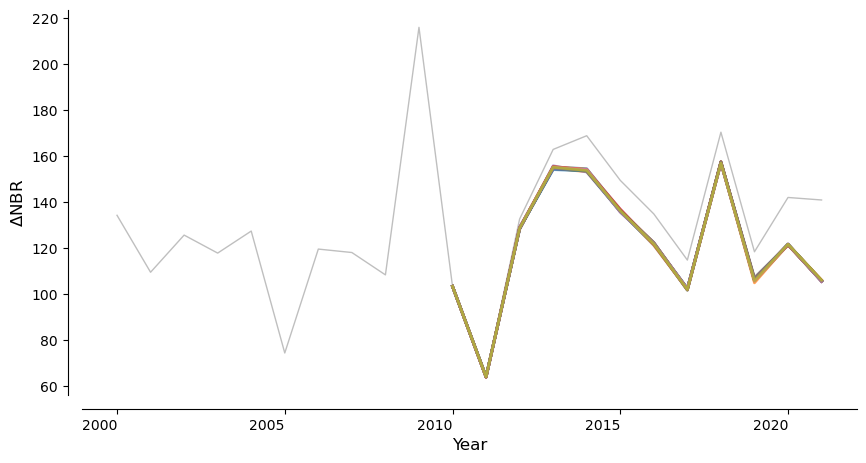

In [27]:
from prescribed.plot import template_plots

arr_sim = xr.concat(arr_lst, dim = "sim")

fig, ax = plt.subplots(figsize=(10, 5))
dnbr_arr.mean(dim=["lat", "lon"]).plot(ax=ax, color='gray', linewidth=1, alpha=0.5)
arr_sim.plot.line(x='year', ax=ax, alpha=0.7, linewidth=2)

# Remove the legend
ax.get_legend().remove()

template_plots(ax=ax, ylab=r"$\Delta$NBR", xlab="Year")

# Add all years to the axis
# xinterval = np.arange(2000, 2022) 
# ax.set_xticks(xinterval)
# ax.set_xticklabels(xinterval, va='center')

# Save plot
plt.savefig("../figs/simulations_conifers_6000.png", dpi=300)

In [18]:
mtbs_ca[mtbs_ca.year == 2020].sort_values("BurnBndAc", ascending=False).iloc[2]

Event_ID                                  CA3720111927220200905
irwinID                    33CBB9DC-6983-4F47-B821-9C9A6CAC381D
Incid_Name                                                CREEK
Incid_Type                                             Wildfire
Map_ID                                                 10020469
Map_Prog                                                   MTBS
Asmnt_Type                                             Extended
BurnBndAc                                                381441
BurnBndLat                                               37.317
BurnBndLon                                             -119.214
Ig_Date                                     2020-09-05 00:00:00
Pre_ID                                          804203420200827
Post_ID                                         804203420210830
Perim_ID                                                   None
dNBR_offst                                                   36
dNBR_stdDv                              

In [89]:
dnbr_arr.sel(year=2020).max()

<xarray.DataArray 'dnbr' ()>
array(1229.1615, dtype=float32)
Coordinates:
    year     int64 2020

In [87]:
(dnbr_arr + sim_data).coeff.sel(year=2020).max()

<xarray.DataArray 'coeff' ()>
array(1181.7245838)
Coordinates:
    year     int64 2020

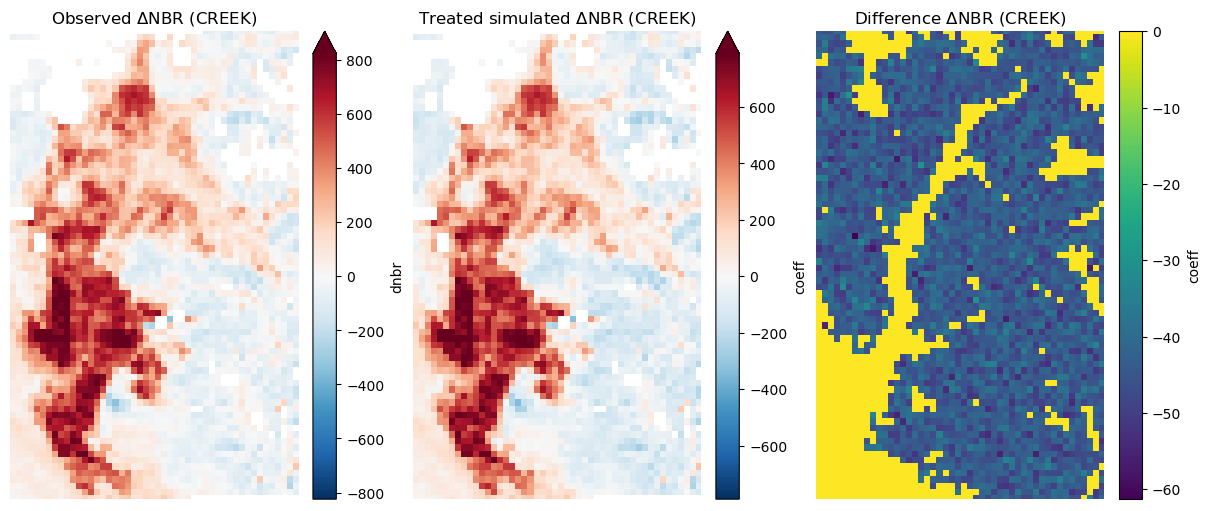

In [86]:
import rioxarray

fig, ax = plt.subplots(1, 3, figsize=(12, 5), layout="constrained")

dnbr_arr.sel(year=2020).plot(ax=ax[0], robust=True)

# Add bounds in x and y
geom = mtbs_ca[mtbs_ca.year == 2020].sort_values("BurnBndAc", ascending=False).iloc[2]
bounds = geom.geometry.bounds 

ax[0].set_xlim(bounds[0], bounds[2])
ax[0].set_ylim(bounds[1], bounds[3])

(dnbr_arr + sim_data).coeff.sel(year=2020).plot(ax=ax[1], robust=True)

ax[1].set_xlim(bounds[0], bounds[2])
ax[1].set_ylim(bounds[1], bounds[3])

sim_data.coeff.sel(year=2020).plot(ax=ax[2])

ax[2].set_xlim(bounds[0], bounds[2])
ax[2].set_ylim(bounds[1], bounds[3])

template_plots(ax=ax[0], no_axis=True, ylab="", xlab="")
template_plots(ax=ax[1], no_axis=True, ylab="", xlab="")
template_plots(ax=ax[2], no_axis=True, ylab="", xlab="")

# Remove titles in ax
ax[0].set_title(rf"Observed $\Delta$NBR ({geom.Incid_Name})")
ax[1].set_title(rf"Treated simulated $\Delta$NBR ({geom.Incid_Name})")
ax[2].set_title(rf"Difference $\Delta$NBR ({geom.Incid_Name})")

# Save plot
plt.savefig("../figs/creek_sims.png", dpi=300)


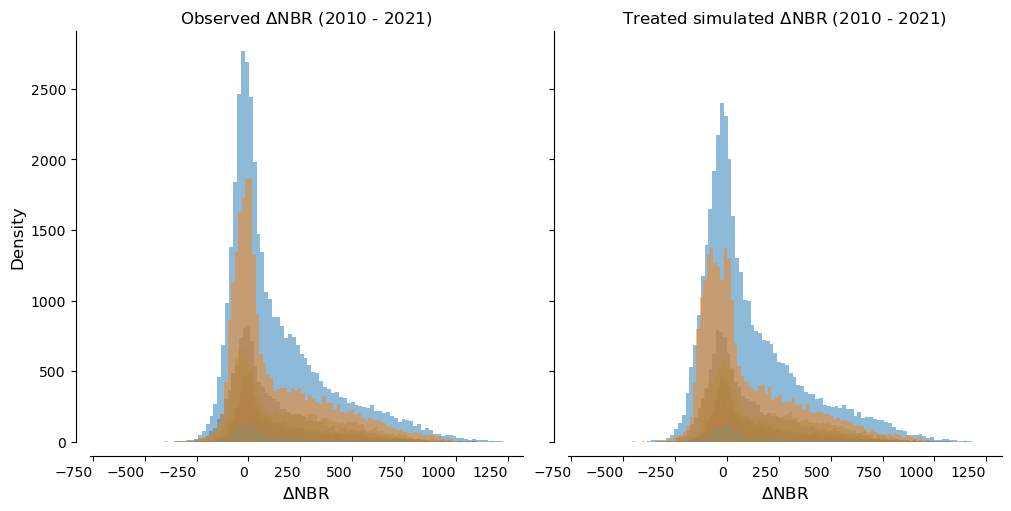

In [63]:
import rioxarray

# fig, ax = plt.subplots(1, 1, figsize=(10, 5), layout="constrained")

# dnbr_arr.sel(year=2015).plot.hist(ax=ax, bins=100)
# (dnbr_arr + sim_data).coeff.sel(year=2015).plot.hist(ax=ax, color='red', bins=100)


# Plot overlapping histograms for all years in the arrays
fig, ax = plt.subplots(1, 2, figsize=(10, 5), layout="constrained", sharex=True, sharey=True)

for year in range(2010, 2022):
    dnbr_arr.sel(year=year).plot.hist(ax=ax[0], bins=100, alpha=0.5)
    (dnbr_arr + sim_data).coeff.sel(year=year).plot.hist(ax=ax[1], bins=100, alpha=0.5)

# Remove titles in ax
ax[0].set_title(r"Observed $\Delta$NBR (2010 - 2021)")
ax[1].set_title(r"Treated simulated $\Delta$NBR (2010 - 2021)")

# Add labels
template_plots(ax=ax[0], xlab=r"$\Delta$NBR", ylab="Density")
template_plots(ax=ax[1], xlab=r"$\Delta$NBR", ylab="")

# Save plot
plt.savefig("../figs/hists_all.png", dpi=300)
